# A / B Testing of a new Landing Page

### The data are results of running an experimental page for one day, recording if a user opts for a new service.

#### Read Data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data/experiment.csv')

In [4]:
data.head(15)

,user_id,ts,ab,landing_page,converted
0,4040615247,1.356998e+09,treatment,new_page,0
1,4365389205,1.356998e+09,treatment,new_page,0
2,4256174578,1.356998e+09,treatment,new_page,0
3,8122359922,1.356998e+09,control,old_page,0
4,6077269891,1.356998e+09,control,old_page,0
5,4275599187,1.356998e+09,treatment,new_page,0
6,1659259079,1.356998e+09,control,old_page,0
7,1545725891,1.356998e+09,control,old_page,0
8,7347566546,1.356998e+09,treatment,new_page,0
9,8944268730,1.356998e+09,control,old_page,0


In [3]:
print('ab column counts:')
print(data['ab'].value_counts())
print('landing_page column counts:')
print(data['landing_page'].value_counts())

ab column counts:
treatment    100333
control       90815
Name: ab, dtype: int64
landing_page column counts:
new_page    95574
old_page    95574
Name: landing_page, dtype: int64


### Clean-Up Data

In [6]:
# some rows have mismatched landing page / control-treatment labels
def find_mismatch(ab_cell, landing_page_cell):
    if ab_cell == 'treatment' and landing_page_cell == 'new_page':
        return 0
    elif ab_cell == 'control' and landing_page_cell == 'old_page':
        return 0
    else:
        return 1
    
f = lambda row: find_mismatch(row['ab'], row['landing_page'])
data['mismatch'] = data.apply(f, axis=1)

In [9]:
data[data['mismatch']==1].shape

(4759, 6)

In [10]:
# drop 4759 rows from data
data = data[data['mismatch']==0]

### Calculate p-value

In [34]:
old = data[data['landing_page']=='old_page']
new = data[data['landing_page']=='new_page']
old_n = old.shape[0] * 1.
new_n = new.shape[0] * 1.
old_convert = old[old['converted']==1].shape[0]
new_convert = new[new['converted']==1].shape[0]
old_conversion = old_convert/old_n
new_conversion = new_convert/new_n

In [39]:
new_conversion - old_conversion

3.979225745387449e-05

**A one tailed z-test is used because we are only interested in lifting the conversion rate. If the lift is larger than 0.1% with statistical significance the new page should be adopted.**

z = (x−μ) / (σ/√n)
z-statistic = (sample mean - population mean) / (sample standard deviation / square root of population size)

In [36]:
from __future__ import division
from numpy import sqrt
import scipy.stats as scs

def z_test(ctr_old, ctr_new, old_n, new_n,
           effect_size=0., two_tailed=True, alpha=.05):
    '''
    Perform z-test to compare two proprtions (e.g., click through rates (ctr)).

        Note: if you set two_tailed=False, z_test assumes H_A is that the effect is
        non-negative, so the p-value is computed based on the weight in the upper tail.

        Arguments:
            ctr_old (float):    baseline proportion (ctr)
            ctr_new (float):    new proportion
            old_n (int):     number of observations in baseline sample
            new_n (int):     number of observations in new sample
            effect_size (float):    size of effect
            two_tailed (bool):  True to use two-tailed test; False to use one-sided test
                                where alternative hypothesis if that effect_size is non-negative
            alpha (float):      significance level

        Returns:
            z-score, p-value, and whether to reject the null hypothesis
    '''
    
    conversion = (ctr_old * old_n + ctr_new * new_n) / \
                 (old_n + new_n)

    se = sqrt(conversion * (1 - conversion) * (1 / old_n + 1 / new_n)) # standard error

    z_score = (ctr_new - ctr_old - effect_size) / se

    if two_tailed:
        p_val = (1 - scs.norm.cdf(abs(z_score))) * 2
    else:
        # Because H_A: estimated effect_size > effect_size
        p_val = 1 - scs.norm.cdf(z_score)
    reject_null = p_val < alpha
    
    return z_score, p_val, reject_null

In [37]:
z_score, p_val, reject_null = z_test(old_conversion, new_conversion, old_n, new_n, effect_size=.001, two_tailed=False, alpha=.05)

In [38]:
print(f'z-score: {z_score}, p-value: {p_val}, reject null: {reject_null}')

z-score: -0.6917276180865002, p-value: 0.7554458002288147, reject null: False


**Based on the p-value alone, the lift is not signigicantly larger than 0.1%. The null is not rejected and the new page is not adopted.**
**This is the result from running the experiment on one day, a weekday. This experiment should run for longer than a day to determint if the new page is effective.**

**When do you stop the experiement? If the p-value is consistent upon the collection of more data over and extended period of time, then we are more confident that the conclusion would stay the same even if the experiment had run on longer.**

In [80]:
def run_test(data):
    old = data[data['landing_page']=='old_page']
    new = data[data['landing_page']=='new_page']
    old_n = old.shape[0] * 1.
    new_n = new.shape[0] * 1.
    old_convert = old[old['converted']==1].shape[0]
    new_convert = new[new['converted']==1].shape[0]
    old_conversion = old_convert/old_n
    new_conversion = new_convert/new_n

    z_score, p_val, reject_null = z_test(old_conversion, new_conversion,
                                         old_n, new_n, effect_size=0.001, two_tailed=True, alpha=.05)
    return p_val, old_conversion, new_conversion

In [81]:
# create a visual aid to see how p-value changes over time

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
def plot_pval(data):
    pval_lst = []
    datetime = data.ts.astype('datetime64[s]')
    hour = datetime.apply(lambda x: x.hour)
    data['hour'] = hour

    # Run the test as the data accumulates hourly
    for hr in hour.unique():
        hr_data = data[data['hour'] <= hr]

        p_val, _, _ = run_test(hr_data)
        
        pval_lst.append(p_val)
    # Make the plot
    plt.plot(pval_lst, marker='o')
    plt.ylabel('p-value', fontweight='bold', fontsize=14)
    plt.xlabel('Hour in the day', fontweight='bold', fontsize=14)
    plt.axhline(0.05, linestyle='--', color='r')

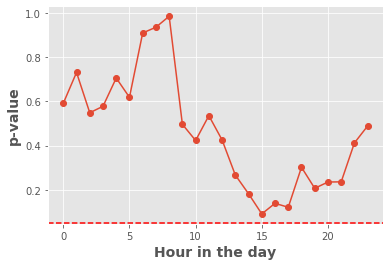

In [82]:
plot_pval(data)

**Since the p-value doesn't remain consistent throughout this experiemnt, it would be best to continue to run it.**

### Segment data further for additional insights

In [83]:
# there is data providing country information about the clicks
def read_country_merge(fname):
    country = pd.read_csv(fname)
    merged_df = pd.merge(data, country, left_on='user_id', right_on='user_id', how='left')
    merged_df['country'] = merged_df['country'].map(str)
    return merged_df
merged_df = read_country_merge('data/country.csv')

In [84]:
def run_country_test(df):
    results = {}
    for country in df['country'].unique():
        country_df = df[df['country']==country]
        p_val, old_conversion, new_conversion = run_test(country_df)
        results[country] = [p_val, new_conversion-old_conversion]
    for country, lst in results.items():
        p_val, conversion_diff = lst
        print(f'{country} | conversion increase: {conversion_diff} | p-value: {p_val}')

In [85]:
merged_df.head()

,user_id,ts,ab,landing_page,converted,mismatch,hour,country
0,4040615247,1.356998e+09,treatment,new_page,0,0,0,US
1,4365389205,1.356998e+09,treatment,new_page,0,0,0,US
2,4256174578,1.356998e+09,treatment,new_page,0,0,0,US
3,8122359922,1.356998e+09,control,old_page,0,0,0,US
4,6077269891,1.356998e+09,control,old_page,0,0,0,UK


In [86]:
merged_df.country.unique()

array(['US', 'UK', 'nan', 'CA'], dtype=object)

In [87]:
run_country_test(merged_df)

US | conversion increase: -0.0016226414750744045 | p-value: 0.1570480657096871
UK | conversion increase: -0.00789128361124257 | p-value: 0.0006993861701642956
nan | conversion increase: -0.008251793120832282 | p-value: 0.20825461557336933
CA | conversion increase: -0.008015860415896317 | p-value: 0.007591236998119033


**The conversion decreases in every country when adopting the new page. In the United Kingdom the decrease is significant, `0.0006<0.0125`. As well as in Canada, `0.0075 < 0.0125`. The alpha value of 0.05 is divided by 4 since 4 tests are ran.
The new page shoud NOT be adopted.**